In the following, we estimate parameters of the stochastic differential equation model of ion channel noise in Hodgkin-Huxley neurons presented in:

> Goldwyn, Joshua H., Nikita S. Imennov, Michael Famulare, and Eric Shea-Brown. “Stochastic Differential Equation Models for Ion Channel Noise in Hodgkin-Huxley Neurons.” Physical Review E 83, no. 4 (2011): 041908. doi:10.1103/PhysRevE.83.041908.

The code was implemented in Fortran 95 and made available in ModelDB: [ModelDB](http://senselab.med.yale.edu/modeldb/ShowModel.asp?model=128502).

(The code is not included in pyABC and neither developed nor maintained by the pyABC developers.)

We start by downloading the code from ModelDB. For this, the ``requests`` package is needed.

In [1]:
import requests
URL = ("https://senselab.med.yale.edu/modeldb/"
       "eavBinDown.cshtml?o=128502&a=23&mime=application/zip")
req = requests.request("GET", URL)

The zip file to which ``URL`` points is stored in memory.
The code is then extracted into a temporary directory and compiled
using ``make HH_run`` provided as part of the download from ModelDB.
The Fortran compiler ``gfortran`` is required for compilation.

In [2]:
import os
from zipfile import ZipFile
import subprocess
import tempfile
from io import BytesIO

tempdir = tempfile.mkdtemp()
archive = ZipFile(BytesIO(req.content))
archive.extractall(tempdir)
ret = subprocess.run(
        ["make", "HH_run"],
        cwd=os.path.join(tempdir, "ModelDBFolder"))
EXEC = os.path.join(tempdir, "ModelDBFolder", "HH_run")

The variable ``EXEC`` points to the executable.

A simulate function is defined which uses the ``subprocess.run`` function to execute the external binary.
The external binary writes to stdout. The output is captured and stored in a pandas dataframe.
This dataframe is returned by the ``simulate`` function.

In [3]:
import pandas as pd
import numpy as np

def simulate(model=3, membrane_dim=10, time_steps=1e4,
             time_step_size=0.01, isi=100, dc=20, noise=0,
             sine_amplitude=0, sine_frequency=0,
             voltage_clamp=1, data_to_print=1, rng_seed=None):
    """
    Simulate the SDE Ion Channel Model defined
    in an external Fortran simulator.
    
    Returns: pandas.DataFrame
        Index: t, Time
        Columns: V, Na, K
        V: Voltage
        Na, K: Proportion of open channels
    """
    if rng_seed is None:
        rng_seed = np.random.randint(2**32-2) + 1
    membrane_area = membrane_dim**2
    re = subprocess.run(
        [EXEC, str(model),
         # the binary cannot very long floats 
         f"{membrane_area:.5f}", str(time_steps),
         str(time_step_size), str(isi), f"{dc:.5f}",
         str(noise), str(sine_amplitude), str(sine_frequency),
         str(voltage_clamp), str(data_to_print),
         str(rng_seed)],
         stdout=subprocess.PIPE)
    df = pd.read_table(BytesIO(re.stdout),
                       delim_whitespace=True,
                       header=None, index_col=0,
                       names=["t", "V", "Na", "K"])
    return df

We run a single simulation and plot the fraction of open "K" channels and open "Na" channels:

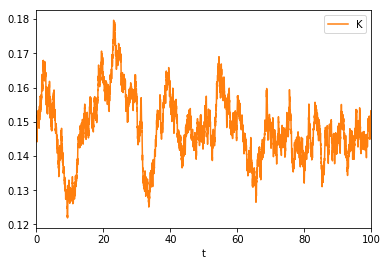

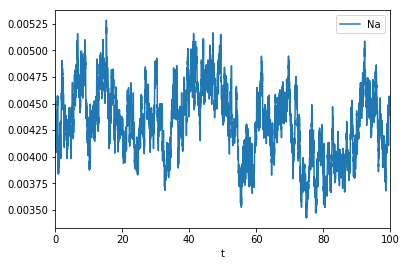

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

gt = {"dc": 20, "membrane_dim": 10}
observation = simulate(**gt, rng_seed=1)
observation.plot(y="K", color="C1");
observation.plot(y="Na", color="C0");

We observe stochastic fluctuations over time.

We'll now demonstrate how to use pyABC to estimate parameters of the model.
Here, we'll focus on the ``dc`` and the ``membrane_dim`` parameters.
The ``dc`` parameter describes the input current, the ``membrane_dim`` is the square root of the membrane area.
We choose uniform priors:

In [5]:
from pyabc import Distribution, RV, ABCSMC

dcmin, dcmax = 10, 30
memmin, memmax = 0.5, 12
prior = Distribution(
    dc=RV("uniform", dcmin, dcmax - dcmin),
    membrane_dim=RV("uniform", memmin, memmax - memmin))

The distance function is defined as $L_2$ norm between the fractions of open "K" channels.

In [6]:
def distance(x, y):
    diff = x["data"]["K"] - y["data"]["K"]
    dist = np.sqrt(np.sum(diff**2))
    return dist

We also define a small ``simulate_pyabc`` wrapper function, which wraps the ``simulate`` function.
This is needed to comply with the interface expected by ``pyABC``.

In [7]:
def simulate_pyabc(parameter):
    res = simulate(**parameter)
    return {"data": res}

We are now ready to start pyABC.
As usually, we first initialize the ABCSMC object,
then pass the observed data and the database location in which to store
the logged parameters and summary statistics,
and finally run the inference until the maximum number of allowed populations
``max_nr_populations`` or the final acceptance threshold ``minimum_epsilon`` is reached.

In [8]:
abc = ABCSMC(simulate_pyabc, prior, distance,
             population_size=25)
abc_id = abc.new("sqlite:///"
                 + os.path.join(tempdir, "test.db"),
                 {"data": observation})
history = abc.run(max_nr_populations=8, minimum_epsilon=1.6)

INFO:Epsilon:initial epsilon is 8.017864030637247
INFO:History:Start <ABCSMC(id=1, start_time=2017-09-19 11:18:07.167109, end_time=None)>
INFO:ABC:t:0 eps:8.01786403064
INFO:ABC:t:1 eps:5.890229498409347
INFO:ABC:t:2 eps:3.7866576982479434
INFO:ABC:t:3 eps:2.347084546432043
INFO:ABC:t:4 eps:1.7179762159832381
INFO:ABC:t:5 eps:1.491204553046473
INFO:History:Done <ABCSMC(id=1, start_time=2017-09-19 11:18:07.167109, end_time=2017-09-19 11:19:06.093635)>


We plot the posterior distribution after a few generations together with the parameters
generating the observed data (the dotted line and the orange dot).

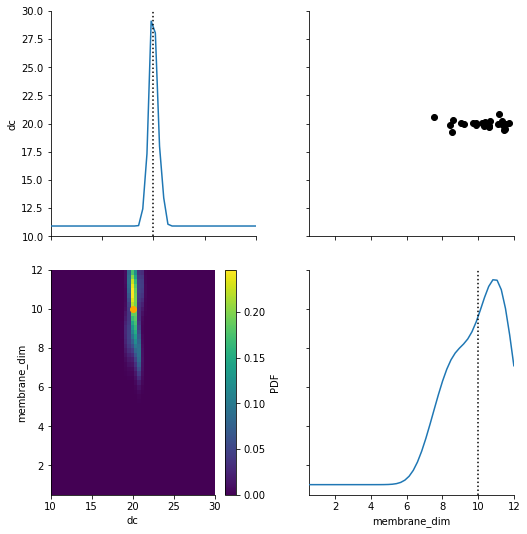

In [9]:
from pyabc.visualization import plot_kde_matrix

dfw = history.get_distribution(m=0)
grid = plot_kde_matrix(*dfw,
                limits={"dc": (dcmin, dcmax),
                        "membrane_dim": (memmin, memmax)});
grid.map_diag(lambda x, **kwargs: plt.gca().axvline(
    gt[x.name], color="k", linestyle="dotted"));
grid.map_lower(lambda x, y, **kwargs: plt.gca().scatter(
    [gt[x.name]], [gt[y.name]], color="orange"));
plt.gcf().set_size_inches(8, 8)

The ``dc`` parameter is very well detected.
(Don't get confused by the y-axis. It applies to the scatterplot, not to the marginal distribution.)
The distribution of ``membrane_dim`` is broader.
(Note that even the exact posterior is not necessarily peaked at the ground truth parameters).

We compare four types of data:

    1) Samples from the prior distribution.
    2) Samples from the posterior distribution.
    3) The data generated by the accepted parameters.
    4) The observation.

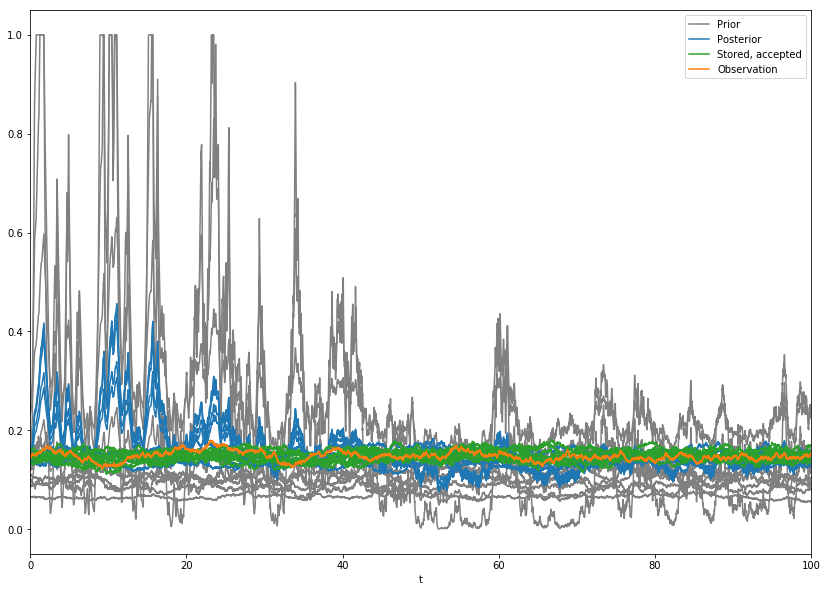

In [10]:
from pyabc.transition import MultivariateNormalTransition

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
n = 10

posterior = MultivariateNormalTransition()
posterior.fit(*history.get_distribution(m=0))

for _ in range(n):
    prior_sample = simulate(**prior.rvs())
    prior_sample.plot(y="K", ax=ax, color="gray")
    
for _ in range(n):
    posterior_sample = simulate(**posterior.rvs())
    posterior_sample.plot(y="K", ax=ax, color="C0")    
    
for stored in history.get_sum_stats(t=history.max_t, m=0)[1][:n]:
    stored["data"].plot(y="K", ax=ax, color="C2")
    
observation.plot(y="K", ax=ax, color="C1")

ax.legend([plt.plot([0], color="gray")[0],
           plt.plot([0], color="C0")[0],
           plt.plot([0], color="C2")[0],
           plt.plot([0], color="C1")[0]], ["Prior", "Posterior", "Stored, accepted", "Observation"]);

We observe that the samples from the prior exhibit the largest variation and do not resemble the observation well.
The samples from the posterior are much closer to the observed data.
Even closer are the samples generated by the accepted parameters.
This has at least two reasons: First, the posterior KDE-fit smoothes the particle populations. Second, the sample generated by a parameter that was accepted is biased towards being more similar to the observed data as compared to a random sample from that parameter.